In [1]:
r"""
This tutorial is focused on the magnon-phonon magnon-damping mechanism
We calculate the damping in a CrSBr monolayer basing on dipole-dipole interaction
between magnons and phonons

-- this is a version of the tutorial where we
a) include both dipole-dipole induced magnon-phonon interaction
and the one derived from displacements
b) calculate the results in a magnetic field B=2T
"""

import numpy as np
import matplotlib.pyplot as plt


import phonopy


import MagnoFallas as mfal

In [2]:
## the following line shoud contain a valid path to the tutorial data
TutorialData = '..//TutorialData'

file1 = TutorialData + '//CrSBr//exchange.out'
SH0 = mfal.ReadTB2J(file1, 1.5)

In [3]:
# The available data for CrSBr includes one inconsistancy in the notation: the y-axis for coordinates
# is considered as z-axis for spin
# the following procedure resolve such an inconsistency
def correctCrSBt(SH0):
    sv0 = np.array((0,1.5,0))
    for at in SH0.magnetic_atoms:
        at.spin_vector = sv0
    
    SHi = mfal.qut.make_FerroHam(SH0)
    for at in SHi.magnetic_atoms:
        at.spin_vector = sv0
    
    return SHi

SH = correctCrSBt(SH0)

In [4]:
# Here we use phonopy API to import phonon data
PHdir = TutorialData + '//CrSBr//'
phonon = phonopy.load(PHdir+"phonopy_disp.yaml", force_sets_filename=PHdir+"FORCE_SETS")

In [5]:
## we create special object to inclode phonons in our code
Ephon = mfal.EXTphonopy(phonon, Adj_ecut=0.1)
Ephon.estimateC(0.0001)
## Adj_ecut and estimateC are tailored to estimate sound velocity and use it to avoid negative phonon frequencies at very small 
## wavevectors

In [6]:
## TB2J and phonopy contain different enumeration of atoms
## these enumerations should be related for the calculations of magnon-phonon interaction
liMag, liAt = mfal.SpinPhonon.relate_TB2J_Phonopy(SH, phonon, dim=2)

In [7]:
### here we define a set of folders containing TB2J results for CrSBr with different strain
## each folder should contain a single important file: 'exchange.out'

dirLst = [TutorialData +'/CrSBr/StrainCrSBr/a/95/', 
          TutorialData +'/CrSBr/StrainCrSBr/a/97/', 
          TutorialData +'/CrSBr/StrainCrSBr/a/102/', 
          TutorialData +'/CrSBr/StrainCrSBr/a/105/', 
          TutorialData +'/CrSBr/StrainCrSBr/b/95/', 
          TutorialData +'/CrSBr/StrainCrSBr/b/97/', 
          TutorialData +'/CrSBr/StrainCrSBr/b/102/', 
          TutorialData +'/CrSBr/StrainCrSBr/b/105/'
]

file0 = 'exchange.out'


In [8]:
# we create a list of spin Hamiltonians with different atom displacements
# and another list of the displacements themselves
# From this information it is possible to destimate, how the shpin Hamiltonian
# depends on atomic positions
SHlist = []
poslist = []
for di in dirLst:
    SHm0 = mfal.ReadTB2J(di + file0, 1.5) 
    SHm = correctCrSBt(SHm0)
    pos = mfal.GetRealPositions(SHm)
    SHlist.append(SHm)
    poslist.append(pos)

pos0 = mfal.GetRealPositions(SH)

In [9]:
# The function
# mfal.SpinPhonon.Estimate_auto_dist
# controls the calculation of magnon-phonon interaction from
# the finite displacements
SPdisp = mfal.SpinPhonon.Estimate_auto_dist(SH, pos0, SHlist, poslist, liMag)

In [10]:
## parameters of the calculation

B0 = 2.0  #external magnetic field (in this version we switch it ON)

Ng = 64   # K-grid size in one dimension
          # 32x32 size of K-grid is relatively small
rk = 0.45  # grid cutoff - allows to focus only on the centrall part of the grid

R0 = 12  #cutoff distance for SRDD/LRDD

MaxBranch = 5   ## maximal number of phonon branch to be included
                ## high optical branches usually have too low occupation numbers to 
                ## play a significant role

In [11]:
NameMC = 'Boltzman-2M1Ph-MCv2'
dampingMC = mfal.damping2M1Ph(SH, Ephon, Ng, Ng, 1, dim=2, rKxM = rk, rKyM = rk, LRdd=True, includeSRDD=True, R0=R0,B=B0,
                             MaxBranch = MaxBranch, Name=NameMC, roles = mfal.roles['PhononMC'],
                             SpinPhon=SPdisp)

# to calculate the magnon damping we create a special object mfal.damping2M1Ph()
# it requires at least the spin Hamiltonian (SH) and information on the phonon (Ephon)
# and information on the K-grid (Ng, rk and dim - grid dimension)
#
# The parameters required to correctly treat the dipole-dipole interaction:
# includeSRDD - shows that short-ranged dipole-dipole interaction shoul be added both to spin Hamiltonian and magnon-phonon interaction
# LRdd - shows that long-range part of dipole-dipole interaction should be taken into account
# R0 - the cutoff distance for SRDD/LRDD
#
# Other parameters:
# roles = mfal.roles['PhononMC'] --- shows that we study the magnon-conserving processes
# B - external magnetic field
# Name - the name of the process (used in Logs and save/load system for scattering events)
#
# In this version of the Tutorial SpinPhon=SPdisp provides the "external" information on the spin-phonon interaction
# from the atomic displacements. Nevertheless, the dipole-dipole interaciton terms are still added inside  mfal.damping2M1Ph

In [12]:
# most important (and sometimes most time-consuming) part of the calculation: initialization of the scattering events
dampingMC.initialize()

dampingMC.saveScatterings()
# the scattering events can be saved for a future use
# dampingMC.loadScatterings()  - the procedure to load them and avoid "initialize()"

In [13]:
## here we select temperatures for the calculation of damping and do the calculation itself
## with the scattering events initialized, this part is usually fast
tt = np.linspace(0.1, 50, 100)
alps = np.array([dampingMC.alpha(t) for t in tt])

In [14]:
## to study the contribution of Non-Magnon-Conserving processes
## we create another instance of damping2M1Ph object
NameNMC = 'Boltzman-2M1Ph-NMCv2'
dampingNMC = mfal.damping2M1Ph(SH, Ephon, Ng, Ng, 1, dim=2, rKxM = rk, rKyM = rk, LRdd=True, includeSRDD=True, R0=R0,B=B0,
                                   MaxBranch = MaxBranch, Name=NameNMC, roles = mfal.roles['PhononNMC'])

dampingNMC.initialize()

In [15]:
alpsNMC = np.array([dampingNMC.alpha(t) for t in tt])

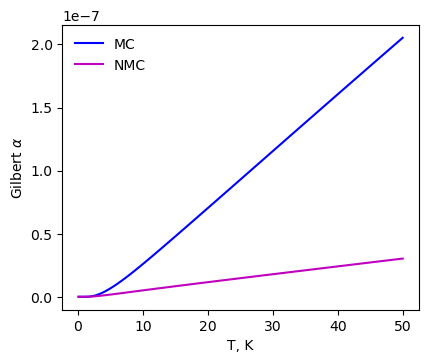

In [16]:
plt.figure(figsize=(4.6,3.7))
plt.plot(tt,alps,'b-', label='MC')
plt.plot(tt,alpsNMC,'m-', label='NMC')

plt.legend(frameon=False)

plt.xlabel('T, K')
plt.ylabel(r'Gilbert $\alpha$')
plt.savefig('CrSBr-phonon-damping-Va.png', bbox_inches='tight')

plt.show()

In [17]:
axisX, axisY, contrMC = dampingMC.phononContrib_2D(50)
print(contrMC.shape)

### to control the calculations (and, in particular, K-grid) it is useful to check the contribution of the different
## k-vecotrs. In 2D (when it is natural to plot the contributions as maps) it can be done with the method
##  .phononContrib_2D(T)
## where T is temperature in K
## the result is axises (useful for plotting) and contrMC array [MaxBranch x Ng x Ng]
## it contains a separate information for each phonon branch

(5, 64, 64)


/tmp/ipykernel_58413/1753269955.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(axisX, axisY, np.transpose(np.log10(ScontMC/np.max(ScontMC))), vmin=-5, cmap='Blues' )


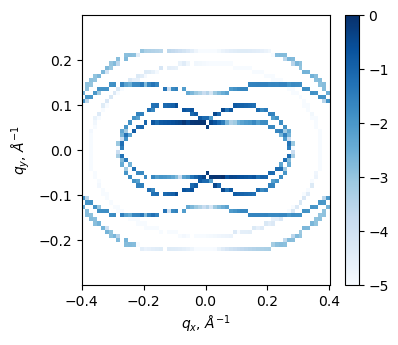

In [18]:
### Here we calculate the total contributions of all the branches and show the result
ScontMC = np.sum(contrMC, axis=0)

plt.figure(figsize=(4.0,3.5))
plt.pcolormesh(axisX, axisY, np.transpose(np.log10(ScontMC/np.max(ScontMC))), vmin=-5, cmap='Blues' )
plt.xlabel(r'$q_x$, $\AA^{-1}$')
plt.ylabel(r'$q_y$, $\AA^{-1}$')
plt.colorbar()

plt.savefig('phonon-contribution-MC-V2.png', bbox_inches='tight')

plt.show()


In [19]:
##Below we do a similar calculations for NMC calculations

axisX2, axisY2, contrNMC = dampingNMC.phononContrib_2D(50)

/tmp/ipykernel_58413/4092813371.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(axisX2, axisY2, np.transpose(np.log10(ScontNMC/np.max(ScontNMC))), vmin=-4, cmap='Reds' )


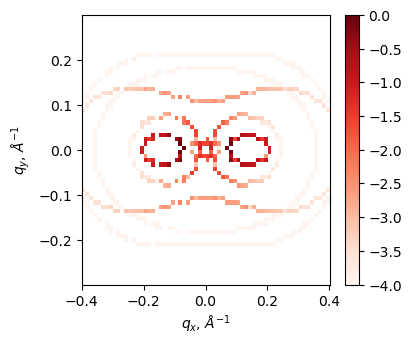

In [20]:
ScontNMC = np.sum(contrNMC, axis=0)

plt.figure(figsize=(4.0,3.5))
plt.pcolormesh(axisX2, axisY2, np.transpose(np.log10(ScontNMC/np.max(ScontNMC))), vmin=-4, cmap='Reds' )
plt.xlabel(r'$q_x$, $\AA^{-1}$')
plt.ylabel(r'$q_y$, $\AA^{-1}$')
plt.colorbar()

plt.savefig('phonon-contribution-NMC-V2.png', bbox_inches='tight')

plt.show()

### It is notable that the distribution of MC processes is almost the same as for B=0
### However magnetic field is important for NMC process
### This is related to different energy conservation laws for the two processes